# Deep Learning: Laparoscopic segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from pytorch_Uformer import model
from pytorch_Uformer import modelPool
from pytorch_Uformer import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

c:\Users\angel\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Descomentar la siguiente linea si tu ordenador no tiene una GPU NVIDIA, y deseas que el código funcione en una CPU en lugar de una GPU
#torch.cuda.is_available(), torch.cuda.get_device_name(0)   

In [3]:
SEED = 17
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [4]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 13
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 100
BATCH_SIZE = 45
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [5]:
IMAGE_DATASET_PATH = glob(f'../*/*/*/frame_*_endo.png')
MASK_DATASET_PATH  = glob(f'../*/*/*/frame_*_endo_watershed_mask.png')
N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 8080


In [6]:
# https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
def resize_with_pad(image: np.array, 
                    new_shape, 
                    padding_color = (0, 0, 0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [7]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i + 1
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = image[10:-10, 120:-120,:]
		image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = mask[10:-10, 120:-120,:]
		mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (13, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [8]:
uformer = model.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=13, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
uformerpool = modelPool.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=13, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
_, testImages, _, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

In [9]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.TverskyLoss().cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()

In [10]:
uformerpool = uformerpool.to(DEVICE)
optpool = torch.optim.Adam(uformerpool.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)

In [11]:
# serialize the model to disk
# torch.save(uformer.state_dict(), '../models/uformer.pth')
uformer.load_state_dict(torch.load('../models/uformer_tversky.pth', map_location=torch.device('cpu')))
uformerpool.load_state_dict(torch.load('../models/uformerpool_tversky.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [12]:
def make_prediction(model, image, toCategorical=True):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		if toCategorical:
			predMask = np.argmax(predMask, axis=-1)
			predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [13]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = image[10:-10, 120:-120,:]
    image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = mask[10:-10, 120:-120,:]
    mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

In [14]:
uformer_pred = []
uformerpool_pred = []
y_true = []

print('[INFO] Loading test images...')
for testImg in tqdm(testImages):
    uformer_pred.append(make_prediction(uformer, getPredImg(testImg), toCategorical=False))
    uformerpool_pred.append(make_prediction(uformerpool, getPredImg(testImg), toCategorical=False))

print('[INFO] Loading test masks...')
for testMask in tqdm(testMasks):
    testMask = getPredMask(testMask)
    y_true.append(testMask)

uformer_pred = np.array(uformer_pred)
uformerpool_pred = np.array(uformerpool_pred)
y_true = np.array(y_true)

assert uformer_pred.shape == y_true.shape, f"{uformer_pred.shape} != {y_true.shape}"

[INFO] Loading test images...


100%|██████████| 1616/1616 [27:51<00:00,  1.03s/it]


[INFO] Loading test masks...


100%|██████████| 1616/1616 [00:11<00:00, 146.66it/s]


In [15]:
labels_encoding = {
    0: 'BG',
    1: 'Abdominal Wall',
    2: 'Liver',
    3: 'Gastrointestinal Tract',
    4: 'Fat',
    5: 'Grasper',
    6: 'Connective Tissue',
    7: 'Blood',
    8: 'Cystic Duct',
    9: 'L-hook Electrocautery',
    10: 'Gallbladder',
    11: 'Hepatic Vein',
    12: 'Liver Ligament',
}

In [16]:
dice = losses.DiceCoeficient().cuda()
iou = losses.MeanIoUBinary().cuda()

uformer_prediction = torch.Tensor(uformer_pred)
uformerpool_prediction = torch.Tensor(uformerpool_pred)
target = torch.Tensor(y_true)

class_losses = {
    'Uformer Dice Coeficient' : [],
    'Uformer IoU' : [],
    'Uformerpool Dice Coeficient' : [],
    'Uformerpool IoU' : [],
}

for i in range(NUM_CLASSES):
    class_losses['Uformer Dice Coeficient'].append(dice(target[:,:,:,i], uformer_prediction[:,:,:,i]).numpy())
    class_losses['Uformer IoU'].append(iou(target[:,:,:,i], uformer_prediction[:,:,:,i]).numpy())
    class_losses['Uformerpool Dice Coeficient'].append(dice(target[:,:,:,i], uformerpool_prediction[:,:,:,i]).numpy())
    class_losses['Uformerpool IoU'].append(iou(target[:,:,:,i], uformerpool_prediction[:,:,:,i]).numpy())
    
class_losses['Uformer Dice Coeficient'].append(dice(target, uformer_prediction).numpy())
class_losses['Uformer IoU'].append(iou(target, uformer_prediction).numpy())
class_losses['Uformerpool Dice Coeficient'].append(dice(target, uformerpool_prediction).numpy())
class_losses['Uformerpool IoU'].append(iou(target, uformerpool_prediction).numpy())

indexes = list(labels_encoding.values())

indexes.append('Final')

df = pd.DataFrame(class_losses, index=indexes)
df['Uformer Dice Coeficient'] = df['Uformer Dice Coeficient'].map('{:.4f}'.format)
df['Uformer IoU'] = df['Uformer IoU'].map('{:.4f}'.format)
df['Uformerpool Dice Coeficient'] = df['Uformerpool Dice Coeficient'].map('{:.4f}'.format)
df['Uformerpool IoU'] = df['Uformerpool IoU'].map('{:.4f}'.format)

df

,Uformer Dice Coeficient,Uformer IoU,Uformerpool Dice Coeficient,Uformerpool IoU
BG,0.9806,0.9620,0.9979,0.9957
Abdominal Wall,0.9480,0.9011,0.9813,0.9634
Liver,0.8978,0.8146,0.9646,0.9316
Gastrointestinal Tract,0.6690,0.5026,0.9323,0.8732
Fat,0.9457,0.8970,0.9647,0.9318
Grasper,0.0000,0.0000,0.8505,0.7398
Connective Tissue,0.0000,0.0000,0.9207,0.8531
Blood,0.0000,0.0000,0.8017,0.6691
Cystic Duct,0.0000,0.0000,0.0000,0.0000
L-hook Electrocautery,0.0000,0.0000,0.9306,0.8702


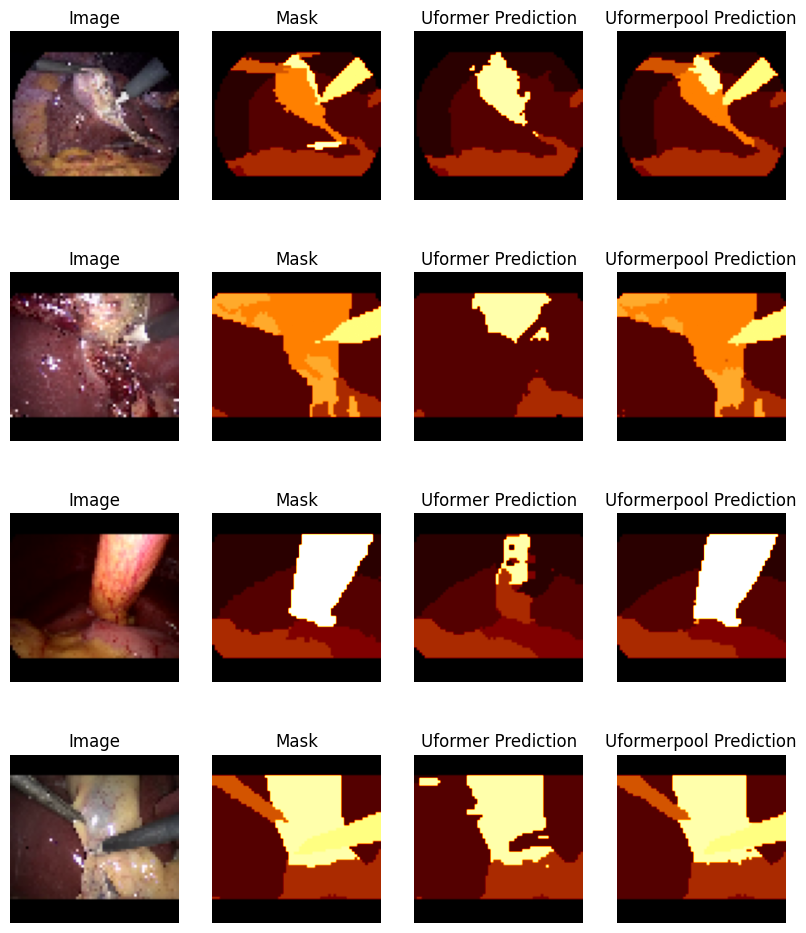

In [17]:
samples = [1561, 1090, 577, 144]
N = len(samples)
plt.figure(figsize=(10,12))
plt.tight_layout()
for i in range(N):    
    idx = samples[i]

    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(N, 4, 1 + 4*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(N, 4, 2 + 4*i)
    plt.imshow(mask, cmap='afmhot', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(N, 4, 3 + 4*i)
    plt.imshow(pred, cmap='afmhot', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Uformer Prediction')
    plt.axis("off")

    pred = make_prediction(uformerpool, img)
    plt.subplot(N, 4, 4 + 4*i)
    plt.imshow(pred, cmap='afmhot', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Uformerpool Prediction')
    plt.axis("off")

plt.show()

--
**TFG - Adrián Contreras Castillo**
--